<center>

## Creation of Hydbrid Linformer Transformer U-Net Architecture for Accurate Brain Tumor Segmentation  (using Autocasting)     


#### By Lawrence Menegus


Note: This Notebook was used in the Publication "LINTUNET: A HYBRID TRANSFORMER-CNN ARCHITECTURE FOR BRAIN TUMOR SEGMENTATION"

This project was conducted on Google Colab, utilizing Google Cloud's computational resources. The results presented below are based on one of several trial runs of the Jupyter notebook. Due to variability in cloud resource allocation, minor differences may occur between runs. However, LinTUNet consistently outperformed U-Net in all trials, but with the degree of improvement varying.

To run this notebook you need to upload the zipped Data_Internship folder to the google drive. Once uploaded you can run this notebook.

You must install packages by the following Command


In [1]:
!pip install pandas numpy matplotlib opencv-python-headless pillow torch torchvision scikit-image tifffile tqdm torchsummary linformer ace-tools-open


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [2]:
import os
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchsummary import summary
from torch.cuda.amp import GradScaler, autocast
from linformer import Linformer
from sklearn.metrics import precision_score, f1_score
import skimage.draw
import shutil
import tifffile
from tqdm import tqdm
import pandas as pd
import ace_tools_open as tools
import warnings
warnings.filterwarnings("ignore")

# Set the device to GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mount Google Drive for CoLab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Lists all the files and folders in directory

In [4]:
ls /content/drive/MyDrive/Publication/

Data_Internship.zip  LinTUnet.ipynb  test/  test_final/  train/  train_final/  valid/  valid_final/


Unzip file for use.

In [5]:
import zipfile
import os

if os.path.exists('/content/drive/MyDrive/Publication/test'):
  print("skipping")
if os.path.exists('/content/drive/MyDrive/Publication/train'):
  print("skipping")
if os.path.exists('/content/drive/MyDrive/Publication/valid'):
  print("skipping")

else:
  zip_path = "/content/drive/MyDrive/Publication/Data_Internship.zip"
  extract_path = '/content/drive/MyDrive/Publication/'

  os.makedirs(extract_path, exist_ok=True)

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)

  print("Dataset unzipped successfully!")

skipping
skipping
skipping


In [6]:
ls /content/drive/MyDrive/Publication/

Data_Internship.zip  LinTUnet.ipynb  test/  test_final/  train/  train_final/  valid/  valid_final/


you should be able to see the the valid train and test folders in
the google drive. these will be used for the model

### Create Paths and Load Data

In [16]:
# Define base directory paths for training, testing, and validation datasets
BASE_DIR = '/content/drive/MyDrive/Publication/'
train_path = os.path.join(BASE_DIR, "train/")
test_path = os.path.join(BASE_DIR, "test/")
valid_path = os.path.join(BASE_DIR, "valid/")



# Load the COCO annotation file containing image segmentation data
with open('/content/drive/MyDrive/Publication/valid/_annotations.coco.json', 'r') as file:
    data = json.load(file)


<center>

## The Application of U-Net


### Brain Tumor Dataset

From [Kaggle](https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation/code)

![](attachment:image.png)

#### Print Data **Annoations**

In [17]:
# Print categories from the COCO annotation file
data['categories']

[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]

### Creating Masks for the Images

In [18]:
def create_mask(image_info, annotations, output_folder, max_print=3):

    # Initialize an empty mask with the same dimensions as the image
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
    printed_masks = 0

    for ann in annotations:

        # Only create masks for the current image
        if ann['image_id'] == image_info['id']:
            for seg_idx, seg in enumerate(ann['segmentation']):

                # Generate the polygon points for the segmentation
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                seg_mask = np.zeros_like(mask_np, dtype=np.uint8)

                # Fill the polygon with white (255) on the mask
                seg_mask[rr, cc] = 255

                # Save the mask as a TIFF file
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
                printed_masks += 1

                #Stops the function
                if printed_masks >= max_print:
                    return


#### Creating a folder directory of Masks and Images

In [19]:
def mask_folders(json_file, mask_output_folder, image_output_folder, original_image_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']

    # Create directories for masks and images if they don't exist
    os.makedirs(mask_output_folder, exist_ok=True)
    os.makedirs(image_output_folder, exist_ok=True)

    # Create masks and copy the original images to the new directories
    for img in images:
        create_mask(img, annotations, mask_output_folder)
        original_image_path = os.path.join(original_image_dir, img['file_name'])

        # Check if the image file exists before trying to copy it
        if os.path.exists(original_image_path):
            new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
            shutil.copy2(original_image_path, new_image_path)
        else:
            print(f"Warning: Image file not found: {original_image_path}")

#### Organize the train, test, and validation datasets into their respective folders

In [20]:
def mask_folders_if_not_exist(json_file, mask_output_folder, image_output_folder, original_image_dir):

    # Check if the output folders exist
    if not os.path.exists(mask_output_folder) or not os.path.exists(image_output_folder):
        # Create output folders if they don't exist
        os.makedirs(mask_output_folder, exist_ok=True)
        os.makedirs(image_output_folder, exist_ok=True)

        # Process the images and masks
        # Update this section with a file existence check inside mask_folders()
        mask_folders(json_file, mask_output_folder, image_output_folder, original_image_dir)
    else:
        print(f"Folders {mask_output_folder} and {image_output_folder} already exist, skipping processing.")

# For 'test' dataset
original_image_dir = '/content/drive/MyDrive/Publication/test'
json_file = '/content/drive/MyDrive/Publication/test/_annotations.coco.json'
mask_output_folder = '/content/drive/MyDrive/Publication/test_final/masks'
image_output_folder = '/content/drive/MyDrive/Publication/test_final/images'
mask_folders_if_not_exist(json_file, mask_output_folder, image_output_folder, original_image_dir)

# For 'train' dataset
original_image_dir = '/content/drive/MyDrive/Publication/train'
json_file = '/content/drive/MyDrive/Publication/train/_annotations.coco.json'
mask_output_folder = '/content/drive/MyDrive/Publication/train_final/masks'
image_output_folder = '/content/drive/MyDrive/Publication/train_final/images'
mask_folders_if_not_exist(json_file, mask_output_folder, image_output_folder, original_image_dir)

# For 'valid' dataset
original_image_dir = '/content/drive/MyDrive/Publication/valid'
json_file = '/content/drive/MyDrive/Publication/valid/_annotations.coco.json'
mask_output_folder = '/content/drive/MyDrive/Publication/valid_final/masks'
image_output_folder = '/content/drive/MyDrive/Publication/valid_final/images'
mask_folders_if_not_exist(json_file, mask_output_folder, image_output_folder, original_image_dir)

Folders /content/drive/MyDrive/Publication/test_final/masks and /content/drive/MyDrive/Publication/test_final/images already exist, skipping processing.
Folders /content/drive/MyDrive/Publication/train_final/masks and /content/drive/MyDrive/Publication/train_final/images already exist, skipping processing.
Folders /content/drive/MyDrive/Publication/valid_final/masks and /content/drive/MyDrive/Publication/valid_final/images already exist, skipping processing.


#### Compares two folders and delete Unmatched items


In [21]:
def compare_folders(folder1_path, folder2_path):

    folder1_items = os.listdir(folder1_path)
    folder2_items = os.listdir(folder2_path)

    # Compare items in folder1 with those in folder2 and delete unmatched items
    for item1 in folder1_items:
        found = False
        for item2 in folder2_items:
            if item1[:4] == item2[:4]:
                found = True
                break
        if not found:
            print(f"Corresponding item for {item1} not found.")
            item1_path = os.path.join(folder1_path, item1)
            os.remove(item1_path)
            print(f"Deleted {item1}")

    # Compare items in folder2 with those in folder1 and delete unmatched items
    for item2 in folder2_items:
        found = False
        for item1 in folder1_items:
            if item2[:4] == item1[:4]:
                found = True
                break
        if not found:
            print(f"Corresponding item for {item2} not found.")
            item2_path = os.path.join(folder2_path, item2)
            os.remove(item2_path)
            print(f"Deleted {item2}")

# Compare and clean up mismatched images and masks in the train folder
folder1_path = "/content/drive/MyDrive/Publication/train_final/images"
folder2_path = "/content/drive/MyDrive/Publication/train_final/masks"
compare_folders(folder1_path, folder2_path)

folder3_path = "/content/drive/MyDrive/Publication/test_final/images"
folder4_path = "/content/drive/MyDrive/Publication/test_final/masks"
compare_folders(folder3_path, folder4_path)

folder5_path = "/content/drive/MyDrive/Publication/valid_final/images"
folder6_path = "/content/drive/MyDrive/Publication/valid_final/masks"
compare_folders(folder5_path, folder6_path)


In [22]:
# Function to split data into train, validation, and test sets
def split_data(image_folder, mask_folder, test_size=0.2, valid_size=0.1):
    # List all image and mask files
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.tif') or f.endswith('.png')])

    # Ensure the images and masks are matched correctly by their file names
    assert len(image_files) == len(mask_files), "Mismatch between image and mask files"

    # Split the data into train and remaining (test + validation)
    train_images, remaining_images, train_masks, remaining_masks = train_test_split(
        image_files, mask_files, test_size=test_size + valid_size, random_state=42
    )

    # Split the remaining data into validation and test
    valid_images, test_images, valid_masks, test_masks = train_test_split(
        remaining_images, remaining_masks, test_size=test_size / (test_size + valid_size), random_state=42
    )

    return train_images, valid_images, test_images, train_masks, valid_masks, test_masks


# Apply the split function to your data
train_images, valid_images, test_images, train_masks, valid_masks, test_masks = split_data(
    image_folder="/content/drive/MyDrive/Publication/train_final/images",
    mask_folder="/content/drive/MyDrive/Publication/train_final/masks"
)

Create Custom function to load
 masks and images to the DataLoaders

In [23]:
class loading_images(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)

        #Load image and converts to RGB
        image = Image.open(img_path).convert("RGB")
        image_gray = image.convert("L")
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")

        #Applying Transformations the image and mask
        if self.transform:
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)

        return image_gray, mask

# Image Transformations for images
image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])



DataLoaders

In [24]:
# Create datasets and dataloaders
train_path = "/content/drive/MyDrive/Publication/train_final"
valid_path = "/content/drive/MyDrive/Publication/valid_final"
test_path = "/content/drive/MyDrive/Publication/test_final"

train_dataset = loading_images(train_path, transform=image_transform)
valid_dataset = loading_images(valid_path, transform=image_transform)
test_dataset = loading_images(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, prefetch_factor=5)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4, prefetch_factor=5)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, prefetch_factor=5)

# Print out some sample data to verify everything is working
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")


Number of training samples: 1501
Number of testing samples: 215
Number of validation samples: 429


### COCO Annoations with Images

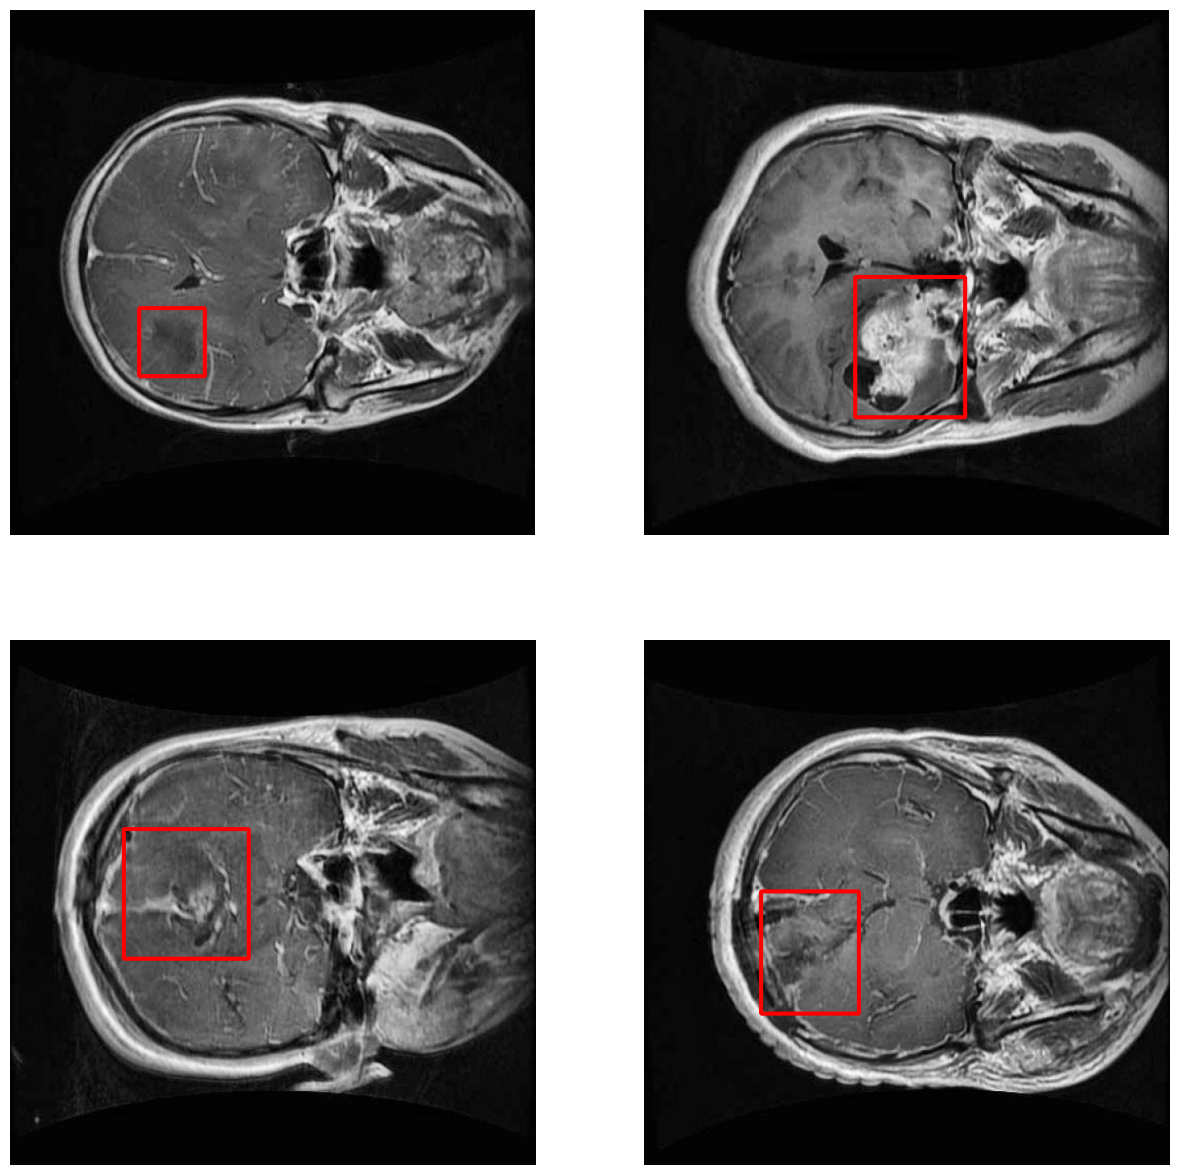

In [36]:
#### Random Sample of MRI Brain Scan
# Function to display a random sample of MRI images with overlaid segmentation masks
def display_masks(image_names, data):

    # Create a 2x2 grid for displaying images
    fig, ax = plt.subplots(2, 2, figsize=(15, 15))
    for i, img_path in enumerate(image_names):
        draw_image = cv2.imread(img_path)
        img_filename = os.path.basename(img_path)

        # Get the image ID from the annotation data based on the filename
        img_id = [item for item in data['images'] if item['file_name'] == img_filename][0]['id']

        # Get the corresponding annotations (segmentation points) for the image
        img_annotations = [ann for ann in data['annotations'] if ann['image_id'] == img_id]
        points_list = img_annotations[0]['segmentation']

        # Convert points to a NumPy array and resphaping for drawling thepolygon
        points = np.array(points_list, np.int32)
        points = points.reshape((-1, 1, 2))

        # Draw the segmentation polygon on the image
        cv2.polylines(draw_image, [points], True, (0, 0, 255), 3)

        # Display the image with the mask
        ax[i // 2, i % 2].imshow(cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB))
        ax[i // 2, i % 2].axis('off')


    plt.show()

# Load and display a random sample of 4 MRI images with their masks
with open('/content/drive/MyDrive/Publication/test/_annotations.coco.json', 'r') as file:
    annotations = json.load(file)
imge_dir = "/content/drive/MyDrive/Publication/test"
all_image_files = [os.path.join(imge_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)
display_masks(random_image_files, annotations)

Basic CNN

In [ ]:
# Define the Double Conv Block
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(0.3)

    def forward(self, x):
        return self.norm(F.relu(self.conv2(F.relu(self.conv1(x)))))

Encoder

In [ ]:
# Define the Downsample Block
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownsampleBlock, self).__init__()
        self.double_conv = DoubleConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.double_conv(x)
        p = self.pool(x)
        return x, p

Decoder

In [ ]:
# Define the Upsample Block
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpsampleBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.double_conv = DoubleConvBlock(in_channels, out_channels)

    def forward(self, x, skip_connection):
        x = self.upconv(x)
        x = torch.cat((x, skip_connection), dim=1)
        return self.double_conv(x)

Unet Architecture (CNN)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.enc1 = DownsampleBlock(in_channels, 64)
        self.enc2 = DownsampleBlock(64, 128)
        self.enc3 = DownsampleBlock(128, 256)
        self.enc4 = DownsampleBlock(256, 512)
        self.bottleneck = DoubleConvBlock(512, 1024)

        self.dec4 = UpsampleBlock(1024, 512)
        self.dec3 = UpsampleBlock(512, 256)
        self.dec2 = UpsampleBlock(256, 128)
        self.dec1 = UpsampleBlock(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1, p1 = self.enc1(x)
        enc2, p2 = self.enc2(p1)
        enc3, p3 = self.enc3(p2)
        enc4, p4 = self.enc4(p3)
        bottleneck = self.bottleneck(p4)
        dec4 = self.dec4(bottleneck, enc4)
        dec3 = self.dec3(dec4, enc3)
        dec2 = self.dec2(dec3, enc2)
        dec1 = self.dec1(dec2, enc1)
        return self.final_conv(dec1)


Summary of the Orginial CNN Unet model

In [ ]:
model = UNet(in_channels=1, out_channels=1).to(DEVICE)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
            Conv2d-2         [-1, 64, 128, 128]          36,928
       BatchNorm2d-3         [-1, 64, 128, 128]             128
   DoubleConvBlock-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
   DownsampleBlock-6  [[-1, 64, 128, 128], [-1, 64, 64, 64]]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
  DoubleConvBlock-10          [-1, 128, 64, 64]               0
        MaxPool2d-11          [-1, 128, 32, 32]               0
  DownsampleBlock-12  [[-1, 128, 64, 64], [-1, 128, 32, 32]]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
           Co

Clears GPU Cache



In [ ]:
torch.cuda.empty_cache()

Defining  Optimizer, Scheduler and Loss Function

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Calculating the Total Parameters and the Total GPU Memory Allocation for the Models to Run

In [ ]:
def model_memory_usage(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    if torch.cuda.is_available():
        allocated_memory = torch.cuda.memory_allocated() / 1024**2
        print(f"GPU Memory Allocated: {allocated_memory:.2f} MB")

Calcuations for How many Seconds it takes to Process a Singular Image

In [ ]:
import time

def measure_inference_time(model, dataloader, device):
    model.eval()
    total_time = 0
    num_samples = 0

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            start_time = time.time()
            _ = model(images)
            end_time = time.time()

            total_time += (end_time - start_time)
            num_samples += images.size(0)

    avg_inference_time = total_time / num_samples
    print(f"Average inference time per image: {avg_inference_time:.6f} seconds")


Calculates:
- The Intersection over Union - How the Generated (predicted) Image Segmentation matches with the Grouund truth Image Segmenation

- Accuracy
- Percision
- Recall
- F1 Score   

of all the models

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_iou(pred_mask, true_mask):
    """
    Args:
        pred_mask (torch.Tensor): The predicted binary segmentation mask (shape: [H, W])
        true_mask (torch.Tensor): The ground truth binary segmentation mask (shape: [H, W])

    Returns:
        float: IoU score
    """
    pred_mask = pred_mask > 0.5  # Threshold predictions
    true_mask = true_mask > 0.5  # Ensure ground truth is binary

    intersection = torch.logical_and(pred_mask, true_mask).sum().float()
    union = torch.logical_or(pred_mask, true_mask).sum().float()

    # If both masks are empty, IoU is 1 (perfect match)
    if union == 0:
        return 1.0

    return (intersection / union).item()


def calculate_metrics(outputs, masks):
    """
    Calculates accuracy, IoU, precision, recall, and F1-score for segmentation tasks.
    """
    # Convert model outputs to binary predictions
    y_pred_binary = (torch.sigmoid(outputs) > 0.5).float()  # Apply sigmoid & threshold

    # **Ensure the ground truth is binary**
    y_true_binary = (masks > 0.5).float()  # Convert ground truth to binary

    # Compute Accuracy
    correct = (y_pred_binary == masks).float().sum()
    accuracy = correct / masks.numel()

    # Compute IoU
    iou = calculate_iou(y_pred_binary, masks)

    # Flatten the tensors for sklearn metrics
    y_pred_np = y_pred_binary.cpu().detach().numpy().flatten()
    y_true_np = y_true_binary.cpu().detach().numpy().flatten()

    # Compute Precision, Recall, and F1-Score
    precision = precision_score(y_true_np, y_pred_np, zero_division=1)
    recall = recall_score(y_true_np, y_pred_np, zero_division=1)
    f1 = f1_score(y_true_np, y_pred_np, zero_division=1)

    return accuracy.item(), iou, precision, recall, f1


# Training the Data

Models' Training Process

Uses:
- Autocasting (Mixed percision) used for speeding up models  no effect on results.
- Grad Scaling

Calcuates per Epoch
- Train and Valid Accuracy
- Train and Valid Loss  
- Train and Valid IOU

In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=20):
    model.train()

    train_losses, train_accuracies, train_ious, train_precisions, train_f1s = [], [], [], [], []
    valid_losses, valid_accuracies, valid_ious, valid_precisions, valid_f1s = [], [], [], [], []

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_accuracy, total_train_iou, total_train_precision, total_train_f1 = 0.0, 0.0, 0.0, 0.0
        scaler = torch.cuda.amp.GradScaler()
        num_batches_train = len(train_loader)

        # Training phase
        for images, masks in tqdm(train_loader):
            images, masks = images.to(DEVICE), masks.to(DEVICE, dtype=torch.float32)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
              # Forward pass: Move this line above metric calculation
              outputs = model(images)

              # Compute loss
              loss = criterion(outputs, masks)

              # Compute metrics
              acc, iou, precision, recall, f1 = calculate_metrics(outputs, masks)

            # Backward pass
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            # Update metrics
            total_train_loss += loss.item()
            total_train_accuracy += acc
            total_train_iou += iou
            total_train_precision += precision
            total_train_f1 += f1

            torch.cuda.empty_cache()

        scheduler.step()

        avg_train_loss = total_train_loss / num_batches_train
        avg_train_accuracy = total_train_accuracy / num_batches_train
        avg_train_iou = total_train_iou / num_batches_train
        avg_train_precision = total_train_precision / num_batches_train
        avg_train_f1 = total_train_f1 / num_batches_train

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
        train_ious.append(avg_train_iou)
        train_precisions.append(avg_train_precision)
        train_f1s.append(avg_train_f1)

        # Validation phase
        model.eval()
        total_valid_loss = 0.0
        total_valid_accuracy, total_valid_iou, total_valid_precision, total_valid_f1 = 0.0, 0.0, 0.0, 0.0
        num_batches_valid = len(valid_loader)

        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE, dtype=torch.float32)

                outputs = model(images)
                loss = criterion(outputs, masks)

                total_valid_loss += loss.item()
                acc, iou, precision, recall, f1 = calculate_metrics(outputs, masks)
                total_valid_accuracy += acc
                total_valid_iou += iou
                total_valid_precision += precision
                total_valid_f1 += f1

        avg_valid_loss = total_valid_loss / num_batches_valid
        avg_valid_accuracy = total_valid_accuracy / num_batches_valid
        avg_valid_iou = total_valid_iou / num_batches_valid
        avg_valid_precision = total_valid_precision / num_batches_valid
        avg_valid_f1 = total_valid_f1 / num_batches_valid

        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_accuracy)
        valid_ious.append(avg_valid_iou)
        valid_precisions.append(avg_valid_precision)
        valid_f1s.append(avg_valid_f1)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc: {avg_train_accuracy:.4f}, Train IoU: {avg_train_iou:.4f}, "
              f"Train Precision: {avg_train_precision:.4f}, Train F1: {avg_train_f1:.4f}, "
              f"Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_accuracy:.4f}, "
              f"Valid IoU: {avg_valid_iou:.4f}, Valid Precision: {avg_valid_precision:.4f}, "
              f"Valid F1: {avg_valid_f1:.4f}")

    return model, train_losses, train_accuracies, train_ious, train_precisions, train_f1s, valid_losses, valid_accuracies, valid_ious, valid_precisions, valid_f1s


Configures PyTorch's CUDA memory allocator to handle memory more efficiently when working with GPUs

In [ ]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


Total Memory allocation for Unet (CNN) pior to Training

In [ ]:
model_memory_usage(model)

Total parameters: 31,036,481
GPU Memory Allocated: 619.55 MB


Train Unet (CNN) Model

In [ ]:
# Train the U-Net model
trained_model_basic_cnn, train_losses, train_accuracies, train_ious, train_precisions, train_f1s, valid_losses, valid_accuracies, valid_ious, valid_precisions, valid_f1s = train_model(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=40
)


## Last Epoch Used in Publication (U-Net)
![image5.png](images/image5.png)

How many Seconds it takes to Process a Singular Image (CNN)

In [ ]:
# Measure Inference Time
measure_inference_time(trained_model_basic_cnn, test_loader, DEVICE)


## Inference time per image Used in Publication (U-Net)
![image4.png](images/image4.png)

Total Memory allocation for Unet (CNN) after to Training

In [ ]:
# Measure Model Memory Usage
model_memory_usage(trained_model_basic_cnn)

Total parameters: 31,036,481
GPU Memory Allocated: 981.61 MB


Save (CNN) Model state for future use

In [ ]:
# Save the trained model
torch.save(trained_model_basic_cnn.state_dict(), "unet_brain_tumor_segmentation.pth")

Visualize the Location and size of the Brain Tumor based on image Segmentation

In [ ]:
# Printout image and Predicted Image Segmentation and True Segmentation
def visualize_unet(input_image, output_image, target_image):
    input_image = input_image.cpu().numpy().squeeze()
    output_image = output_image.cpu().numpy().squeeze()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_image, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(output_image, cmap='gray')
    axes[1].set_title('Output Image (Predicted)')
    axes[1].axis('off')

    plt.show()

with torch.inference_mode():
    sample_count = 0
    max_samples = 5

    for batch, (X, y) in enumerate(valid_loader):

        if sample_count >= max_samples:
            break
        X = X.to(DEVICE, dtype=torch.float32)
        y = y.to(DEVICE, dtype=torch.float32)

        y_pred_logits = trained_model_basic_cnn(X)
        y_pred_binary = (y_pred_logits > 0.5).float()
        visualize_unet(X[0], y_pred_binary[0], y[0])
        sample_count += 1

## Segmenation Used for Publication (Unet)
![image.png](images/image.png)

### Hybrid CNN/Transformer Unet I call it SparseTransUnet

Uses: Linformer attention layer to process the bottleneck part of the (CNN)


In [ ]:
# Define the Sparse Attention Block (Using Linformer for efficient self-attention)
class AttentionBlock(nn.Module):
    def __init__(self, dim, seq_len, heads=1, depth=1, k=64):
        super().__init__()
        self.linformer = Linformer(
            dim=dim, seq_len=seq_len, depth=depth, heads=heads, k=k
        )

    def forward(self, x):
        return self.linformer(x)

# Define the SparseTransformer UNet Architecture
class LinTransUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LinTransUNet, self).__init__()
        self.enc1 = DownsampleBlock(in_channels, 64)
        self.enc2 = DownsampleBlock(64, 128)
        self.enc3 = DownsampleBlock(128, 256)
        self.enc4 = DownsampleBlock(256, 512)

        # Transformer-based bottleneck
        self.attention = AttentionBlock(dim=512, seq_len=16*16)
        self.bottleneck = DoubleConvBlock(512, 1024)

        self.dec4 = UpsampleBlock(1024, 512)
        self.dec3 = UpsampleBlock(512, 256)
        self.dec2 = UpsampleBlock(256, 128)
        self.dec1 = UpsampleBlock(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1, p1 = self.enc1(x)
        enc2, p2 = self.enc2(p1)
        enc3, p3 = self.enc3(p2)
        enc4, p4 = self.enc4(p3)

        # Apply sparse transformer-based attention
        b, c, h, w = p4.shape

        # Convert to sequence
        p4 = p4.flatten(2).transpose(1, 2)
        p4 = self.attention(p4)

        # Convert back to image shape
        p4 = p4.transpose(1, 2).view(b, c, h, w)

        bottleneck = self.bottleneck(p4)
        dec4 = self.dec4(bottleneck, enc4)
        dec3 = self.dec3(dec4, enc3)
        dec2 = self.dec2(dec3, enc2)
        dec1 = self.dec1(dec2, enc1)
        return self.final_conv(dec1)



Architecture of the Hybrid Model

In [ ]:
# Model Initialization
lin_model = LinTransUNet(in_channels=1, out_channels=1).to(DEVICE)
summary(lin_model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
            Conv2d-2         [-1, 64, 128, 128]          36,928
       BatchNorm2d-3         [-1, 64, 128, 128]             128
   DoubleConvBlock-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
   DownsampleBlock-6  [[-1, 64, 128, 128], [-1, 64, 64, 64]]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
  DoubleConvBlock-10          [-1, 128, 64, 64]               0
        MaxPool2d-11          [-1, 128, 32, 32]               0
  DownsampleBlock-12  [[-1, 128, 64, 64], [-1, 128, 32, 32]]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
           Co

SparseTransUnet's Optimizer

In [ ]:
optimizer = optim.Adam(lin_model.parameters(), lr=0.001)

Total Memory allocation for Unet Hybrid (Transformer-CNN) pior to Training

In [ ]:
model_memory_usage(lin_model)

Total parameters: 34,220,097
GPU Memory Allocated: 1135.21 MB


Hybrid model's Training

In [ ]:
# Train the U-Net model
trained_model_lin, train_losses_lin, train_accuracies_lin, train_ious_lin, train_precisions_lin, train_f1s_lin, valid_losses_lin, valid_accuracies_lin, valid_ious_lin, valid_precisions_lin, valid_f1s_lin = train_model(
    lin_model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=40
)

## Final Epoch Used in Publication (LinTUNet)
![image2.png](images/image2.png)

How many Seconds it takes to Process a Singular Image (Transformer-CNN)

In [ ]:
# Measure Inference Time
measure_inference_time(trained_model_lin, test_loader, DEVICE)

## Inference time per image Used in Publication (LinTUNet)
![image3.png](images/image3.png)

Total Memory allocation for Unet Hybrid (Transformer-CNN) after to Training

In [ ]:
# Measure Model Memory Usage
model_memory_usage(trained_model_lin)

Total parameters: 34,220,097
GPU Memory Allocated: 1540.25 MB


Visualization of The hydbrid model

In [ ]:
# Printout image and Predicted Image Segmentation and True Segmentation
def visualize_unet(input_image, output_image, target_image):
    input_image = input_image.cpu().numpy().squeeze()
    output_image = output_image.cpu().numpy().squeeze()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_image, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(output_image, cmap='gray')
    axes[1].set_title('Output Image (Predicted)')
    axes[1].axis('off')

    plt.show()
    fig.savefig("output.png")

with torch.inference_mode():
    sample_count = 0
    max_samples = 5

    for batch, (X, y) in enumerate(valid_loader):

        if sample_count >= max_samples:
            break
        X = X.to(DEVICE, dtype=torch.float32)
        y = y.to(DEVICE, dtype=torch.float32)

        y_pred_logits = trained_model_lin(X)
        y_pred_binary = (y_pred_logits > 0.5).float()
        visualize_unet(X[0], y_pred_binary[0], y[0])
        sample_count += 1

## Segmenation Used for Publication (LinTUnet)
![image10.png](images/image10.png)

Plotting the Loss function and Accuracy of models

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Convert accuracy lists to CPU and then to NumPy arrays
train_accuracies_np = np.array([acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracies])
valid_accuracies_np = np.array([acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in valid_accuracies])

train_accuracies_lin = np.array([acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracies_lin])
valid_accuracies_lin = np.array([acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in valid_accuracies_lin])

# Convert loss lists to NumPy arrays
train_losses_np = np.array(train_losses)
valid_losses_np = np.array(valid_losses)
train_losses_lin = np.array(train_losses_lin)
valid_losses_lin = np.array(valid_losses_lin)

# Define fixed y-axis ranges
min_epoch = 0  # Assuming epochs start at 0
max_epoch = 35  # Set max based on number of epochs


min_loss = min(train_losses_np.min(), valid_losses_np.min(), train_losses_lin.min(), valid_losses_lin.min())
max_loss = 0.6  # Upper limit fixed at 0.6
min_acc = 0.8  # Accuracy starts from 0
max_acc = 1.0  # Upper limit fixed at 1.0



CNN loss

In [ ]:
# Create plots with fixed axis scaling
fig, axes = plt.subplots(1, figsize=(10, 5))

# Plot Loss
axes.plot(train_losses_np, label='Train Loss')
axes.plot(valid_losses_np, label='Validation Loss')
axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')
axes.set_title('Training and Validation Loss')
axes.legend()
axes.set_ylim(min_loss, max_loss)  # Set fixed y-axis limits
axes.set_xlim(min_epoch, max_epoch)  # CNN Loss
axes.set_aspect(1.0 / axes.get_data_ratio())  # Make box square

plt.tight_layout()
plt.show()

# Loss Function Used in Publication (U-Net) 
![image6.png](images/image6.png)

Hybrid Loss

In [ ]:
# Create plots with fixed axis scaling
fig, axes = plt.subplots(1, figsize=(10, 5))

# Plot Loss
axes.plot(train_losses_lin, linestyle='dashed', label='Train Loss')
axes.plot(valid_losses_lin, linestyle='dashed', label='Validation Loss')
axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')
axes.set_title('Training and Validation Loss')
axes.legend()
axes.set_ylim(min_loss, max_loss)  # Set fixed y-axis limits
axes.set_xlim(min_epoch, max_epoch) # fixed x-axis
axes.set_aspect(1.0 / axes.get_data_ratio())  # Make box square

plt.tight_layout()
plt.show()

# Loss Function Used in Publication (LinTUNet) 
![image7.png](images/image7.png)

CNN Accuracy

In [ ]:
# Create plots with fixed axis scaling
fig, axes = plt.subplots(1, figsize=(10, 5))

# Plot Accuracy
axes.plot(train_accuracies_np, label='Train Accuracy')
axes.plot(valid_accuracies_np, label='Validation Accuracy')
axes.set_xlabel('Epochs')
axes.set_ylabel('Accuracy')
axes.set_title('Training and Validation Accuracy')
axes.legend()
axes.set_ylim(min_acc, max_acc)  # Set fixed y-axis limits
axes.set_xlim(min_epoch, max_epoch)
axes.set_aspect(1.0 / axes.get_data_ratio())  # Make box square

plt.tight_layout()
plt.show()

## Accuracy Used in Publication (U-Net)
![image8.png](images/image8.png)

Hybrid Accuracy

In [ ]:
# Create plots with fixed axis scaling
fig, axes = plt.subplots(1,figsize=(10, 5))

# Plot Accuracy
axes.plot(train_accuracies_lin, linestyle='dashed', label='Train Accuracy ')
axes.plot(valid_accuracies_lin, linestyle='dashed', label='Validation Accuracy ')
axes.set_xlabel('Epochs')
axes.set_ylabel('Accuracy')
axes.set_title('Training and Validation Accuracy')
axes.legend()
axes.set_ylim(min_acc, max_acc)  # Set fixed y-axis limits
axes.set_xlim(min_epoch, max_epoch)
axes.set_aspect(1.0 / axes.get_data_ratio())  # Make box square

plt.tight_layout()
plt.show()

## Accuracy Used in Publication (LinTUNet)
![image9.png](images/image9.png)

Comparisons of the Accuracies and IoU's of each model

In [ ]:
data = {
    "Metric": ["F1 Score (Train)", "Accuracy (Train)", "IoU (Train)", "Precision (Train)"],
    "Unet (CNN)": [train_f1s[-1], train_accuracies_np[-1], train_ious[-1], train_precisions[-1]],
    "Hybrid Unet (Transformer-CNN)": [train_f1s_lin[-1], train_accuracies_lin[-1], train_ious_lin[-1], train_precisions[-1]]
}

df = pd.DataFrame(data)
tools.display_dataframe_to_user(name = " " , dataframe=df)

## Metrics Used in Publication
![image11.png](images/image11.png)